In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 12.9 MB/s eta 0:00:00


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00


In [3]:
!pip install torch

In [4]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from rdkit import Chem
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [5]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available.")

Using device: cuda
CUDA is available!
Device count: 1
Current device: 0
Device name: Tesla T4


In [6]:
# Load the dataset
file_path = 'zinc.csv'  # Adjust to your file path
df = pd.read_csv(file_path)
# Use a subset of 10,000 samples
df = df.sample(n=50000, random_state=42).reset_index(drop=True)


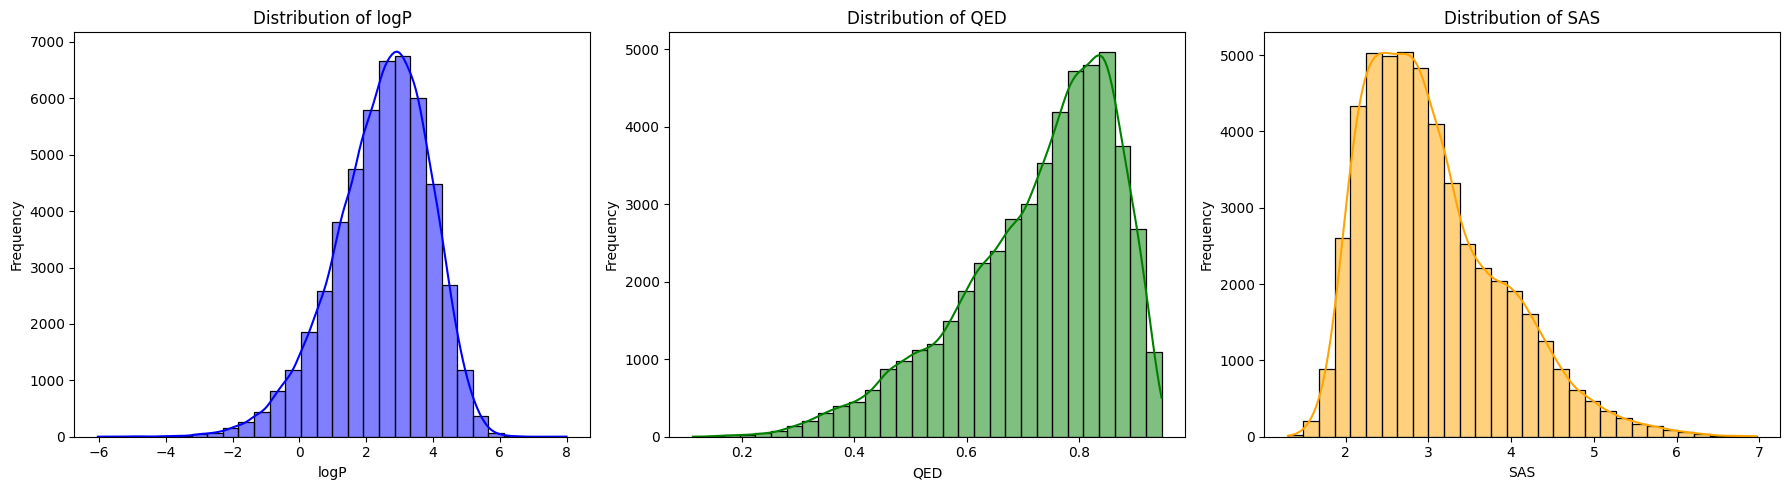

In [7]:
# Assuming df is your DataFrame that contains logP, qed, and sas columns
plt.figure(figsize=(18, 5))

# logP distribution
plt.subplot(1, 3, 1)
sns.histplot(df['logP'], bins=30, kde=True, color='blue')
plt.title('Distribution of logP')
plt.xlabel('logP')
plt.ylabel('Frequency')

# QED distribution
plt.subplot(1, 3, 2)
sns.histplot(df['qed'], bins=30, kde=True, color='green')
plt.title('Distribution of QED')
plt.xlabel('QED')
plt.ylabel('Frequency')

# SAS distribution
plt.subplot(1, 3, 3)
sns.histplot(df['SAS'], bins=30, kde=True, color='orange')
plt.title('Distribution of SAS')
plt.xlabel('SAS')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [8]:
# Check missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

# Drop rows with missing values
df = df.dropna()




Missing values:
 Series([], dtype: int64)


In [9]:
# Load ChemBERTa tokenizer and model using RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('seyonec/ChemBERTa-zinc-base-v1')
chemberta_model = RobertaModel.from_pretrained('seyonec/ChemBERTa-zinc-base-v1').to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [10]:
# Function to convert SMILES to ChemBERTa embeddings
def smiles_to_chemberta_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = chemberta_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)


In [11]:
# Convert SMILES strings to molecular graphs
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    edge_index = []
    edge_attr = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # Undirected graph
        edge_type = bond.GetBondTypeAsDouble()
        edge_attr.append(edge_type)
        edge_attr.append(edge_type)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [12]:
# Convert SMILES strings to molecular graphs and ChemBERTa embeddings
graphs = []
chemberta_embeddings = []
for smiles in tqdm(df['smiles'], desc="Processing SMILES"):
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs.append(graph)
        chemberta_embeddings.append(smiles_to_chemberta_embedding(smiles))

Processing SMILES: 100%|██████████| 50000/50000 [05:40<00:00, 147.01it/s]


In [13]:
# Concatenate ChemBERTa embeddings with graph node features
for graph, chemberta_embedding in tqdm(zip(graphs, chemberta_embeddings), desc="Concatenating embeddings"):
    repeated_embedding = chemberta_embedding.repeat(graph.x.size(0), 1)
    graph.x = torch.cat([graph.x.to(device), repeated_embedding], dim=1)


Concatenating embeddings: 50000it [00:04, 11261.17it/s]


In [14]:
# Create separate data lists for (logP, QED) and SAS models
logp_qed_data = []
sas_data = []

for i, graph in enumerate(graphs):
    logp, qed, sas = df.iloc[i][['logP', 'qed', 'SAS']]

    # Append (logP, QED) data
    logp_qed_graph = graph.clone()
    logp_qed_graph.y = torch.tensor([logp, qed], dtype=torch.float).to(device)
    logp_qed_data.append(logp_qed_graph)

    # Append SAS data
    if not pd.isnull(sas):
        sas_graph = graph.clone()
        sas_graph.y = torch.tensor([sas], dtype=torch.float).to(device)
        sas_data.append(sas_graph)


In [15]:
# Split data into train and test sets
logp_qed_train, logp_qed_test = train_test_split(logp_qed_data, test_size=0.2, random_state=42)
sas_train, sas_test = train_test_split(sas_data, test_size=0.2, random_state=42)


In [16]:
# Create DataLoaders
logp_qed_train_loader = DataLoader(logp_qed_train, batch_size=32, shuffle=True)
logp_qed_test_loader = DataLoader(logp_qed_test, batch_size=32, shuffle=False)
if sas_train:
    sas_train_loader = DataLoader(sas_train, batch_size=32, shuffle=True)
else:
    print("No valid SAS training data available.")

if sas_test:
    sas_test_loader = DataLoader(sas_test, batch_size=32, shuffle=False)
else:
    print("No valid SAS test data available.")


In [17]:

# Initialize GAT model
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=1, concat=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gat1(x, edge_index))
        x = F.relu(self.gat2(x, edge_index))
        x = global_mean_pool(x, data.batch)
        out = self.fc(x)
        return out

In [18]:
# Define metric calculation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # MAPE calculation, avoiding division by zero
    non_zero_indices = y_true != 0
    if np.any(non_zero_indices):
        mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    else:
        mape = np.nan

    return mse, rmse, mae, r2, mape

In [19]:
# Modify the train function
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data)
        target = data.y.view(out.shape).to(device)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [20]:
# Modify the evaluate function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    y_trues, y_preds = [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            target = data.y.view(out.shape).to(device)
            loss = criterion(out, target)
            total_loss += loss.item() * data.num_graphs

            y_trues.append(target.cpu().numpy())
            y_preds.append(out.cpu().numpy())

    y_trues = np.concatenate(y_trues, axis=0)
    y_preds = np.concatenate(y_preds, axis=0)

    return total_loss / len(loader.dataset), y_trues, y_preds


In [21]:
# Initialize GAT model for logP/QED and SAS
input_dim = graphs[0].x.shape[1]
hidden_dim = 64

logp_qed_model = GAT(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=2).to(device)
sas_model = GAT(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1).to(device)


In [22]:
# Define optimizers and loss function
logp_qed_optimizer = optim.Adam(logp_qed_model.parameters(), lr=0.001)
sas_optimizer = optim.Adam(sas_model.parameters(), lr=0.001)

criterion = torch.nn.MSELoss()


In [23]:
# Train logP and QED model
num_epochs = 20
logp_qed_train_losses = []
logp_qed_val_losses = []

for epoch in range(num_epochs):
    train_loss = train(logp_qed_model, logp_qed_train_loader, logp_qed_optimizer, criterion, device)
    val_loss, y_true_val, y_pred_val = evaluate(logp_qed_model, logp_qed_test_loader, criterion)

    logp_qed_train_losses.append(train_loss)
    logp_qed_val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch [1/20], Train Loss: 0.3407, Val Loss: 0.2919
Epoch [2/20], Train Loss: 0.2409, Val Loss: 0.2567
Epoch [3/20], Train Loss: 0.2155, Val Loss: 0.2294
Epoch [4/20], Train Loss: 0.2048, Val Loss: 0.2045
Epoch [5/20], Train Loss: 0.1929, Val Loss: 0.1996
Epoch [6/20], Train Loss: 0.1856, Val Loss: 0.1954
Epoch [7/20], Train Loss: 0.1783, Val Loss: 0.1858
Epoch [8/20], Train Loss: 0.1752, Val Loss: 0.1849
Epoch [9/20], Train Loss: 0.1710, Val Loss: 0.1945
Epoch [10/20], Train Loss: 0.1644, Val Loss: 0.1775
Epoch [11/20], Train Loss: 0.1593, Val Loss: 0.1813
Epoch [12/20], Train Loss: 0.1572, Val Loss: 0.1767
Epoch [13/20], Train Loss: 0.1530, Val Loss: 0.1696
Epoch [14/20], Train Loss: 0.1509, Val Loss: 0.1663
Epoch [15/20], Train Loss: 0.1459, Val Loss: 0.1730
Epoch [16/20], Train Loss: 0.1424, Val Loss: 0.1842
Epoch [17/20], Train Loss: 0.1412, Val Loss: 0.1634
Epoch [18/20], Train Loss: 0.1369, Val Loss: 0.1693
Epoch [19/20], Train Loss: 0.1344, Val Loss: 0.1687
Epoch [20/20], Train 

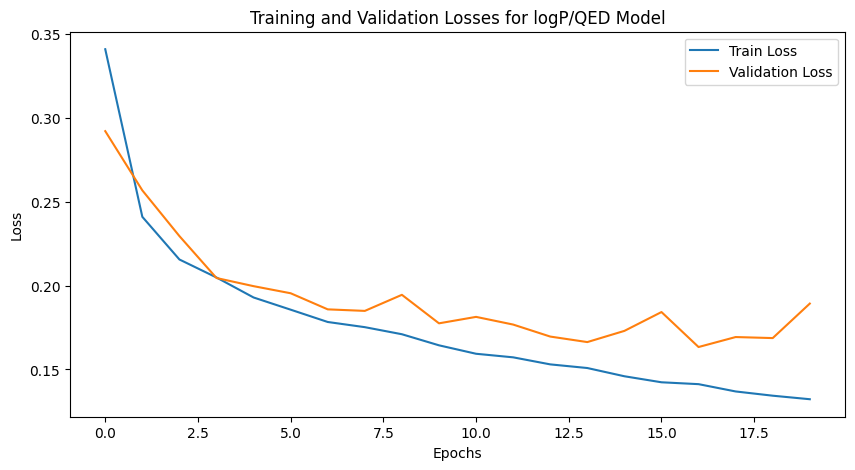

In [24]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(logp_qed_train_losses, label='Train Loss')
plt.plot(logp_qed_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for logP/QED Model')
plt.legend()
plt.show()


In [25]:

# Calculate metrics for logP and QED predictions
mse, rmse, mae, r2, mape = calculate_metrics(y_true_val, y_pred_val)
print(f"LogP/QED Model - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%")

LogP/QED Model - MSE: 0.1892, RMSE: 0.4350, MAE: 0.2742, R2: 0.7189, MAPE: 33.62%


In [26]:
# Train SAS model
sas_train_losses = []
sas_val_losses = []

for epoch in range(num_epochs):
    train_loss = train(sas_model, sas_train_loader, sas_optimizer, criterion, device)
    val_loss, y_true_val, y_pred_val = evaluate(sas_model, sas_test_loader, criterion)

    sas_train_losses.append(train_loss)
    sas_val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch [1/20], Train Loss: 0.1193, Val Loss: 0.0676
Epoch [2/20], Train Loss: 0.0642, Val Loss: 0.0551
Epoch [3/20], Train Loss: 0.0548, Val Loss: 0.0561
Epoch [4/20], Train Loss: 0.0511, Val Loss: 0.0475
Epoch [5/20], Train Loss: 0.0471, Val Loss: 0.0495
Epoch [6/20], Train Loss: 0.0442, Val Loss: 0.0453
Epoch [7/20], Train Loss: 0.0430, Val Loss: 0.0437
Epoch [8/20], Train Loss: 0.0403, Val Loss: 0.0577
Epoch [9/20], Train Loss: 0.0387, Val Loss: 0.0461
Epoch [10/20], Train Loss: 0.0372, Val Loss: 0.0397
Epoch [11/20], Train Loss: 0.0356, Val Loss: 0.0454
Epoch [12/20], Train Loss: 0.0350, Val Loss: 0.0369
Epoch [13/20], Train Loss: 0.0342, Val Loss: 0.0374
Epoch [14/20], Train Loss: 0.0324, Val Loss: 0.0515
Epoch [15/20], Train Loss: 0.0319, Val Loss: 0.0424
Epoch [16/20], Train Loss: 0.0313, Val Loss: 0.0440
Epoch [17/20], Train Loss: 0.0303, Val Loss: 0.0485
Epoch [18/20], Train Loss: 0.0295, Val Loss: 0.0376
Epoch [19/20], Train Loss: 0.0284, Val Loss: 0.0407
Epoch [20/20], Train 

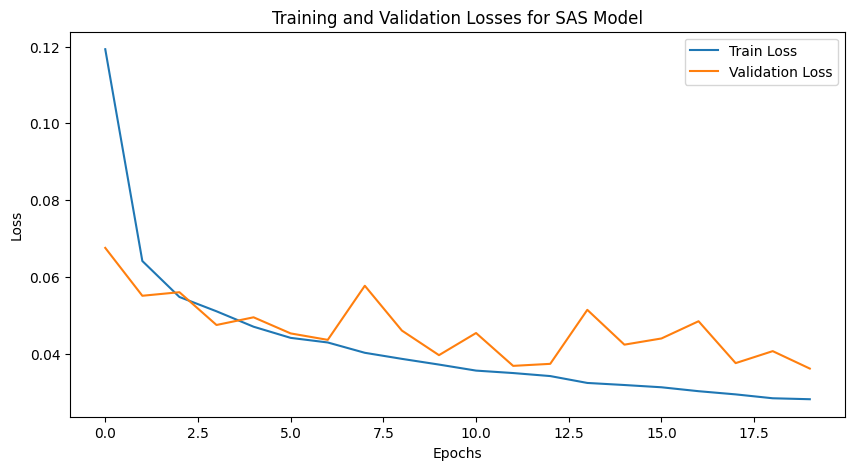

In [27]:
# Plot training and validation losses for SAS model
plt.figure(figsize=(10, 5))
plt.plot(sas_train_losses, label='Train Loss')
plt.plot(sas_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for SAS Model')
plt.legend()
plt.show()


In [28]:
# Calculate metrics for SAS predictions
if sas_test:
    mse, rmse, mae, r2, mape = calculate_metrics(y_true_val, y_pred_val)
    print(f"SAS Model - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%")
else:
    print("No valid SAS test data available.")


SAS Model - MSE: 0.0362, RMSE: 0.1902, MAE: 0.1403, R2: 0.9488, MAPE: 4.58%


In [29]:
# Save the trained models
#torch.save(logp_qed_model.state_dict(), 'logp_qed_model.pth')
torch.save(logp_qed_model, "logp_qed_model_complete.pth")
torch.save(sas_model, "sas_model_complete.pth")
#torch.save(sas_model.state_dict(), 'sas_model.pth')

In [30]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 8.0 MB/s eta 0:00:00


In [31]:
!pip install pyngrok

In [32]:
# Remove non-printable characters from the code
with open('/content/app.py', 'w') as f:
    code = """
import streamlit as st
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import Draw
from transformers import RobertaTokenizer, RobertaModel

# Initialize GAT model
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=1, concat=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gat1(x, edge_index))
        x = F.relu(self.gat2(x, edge_index))
        x = global_mean_pool(x, data.batch)
        out = self.fc(x)
        return out

# Load the entire models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the saved models directly
logp_qed_model = torch.load("logp_qed_model_complete.pth", map_location=device)
sas_model = torch.load("sas_model_complete.pth", map_location=device)

# Set models to evaluation mode
logp_qed_model.eval()
sas_model.eval()

# Load the ChemBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('seyonec/ChemBERTa-zinc-base-v1')
chemberta_model = RobertaModel.from_pretrained('seyonec/ChemBERTa-zinc-base-v1').to(device)

# Function to convert SMILES to ChemBERTa embedding
def smiles_to_chemberta_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = chemberta_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# Function to convert SMILES to graph
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        st.error("Failed to parse SMILES string. Please check the input.")
        return None

    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    edge_index = []
    edge_attr = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # Undirected graph
        edge_type = bond.GetBondTypeAsDouble()
        edge_attr.append(edge_type)
        edge_attr.append(edge_type)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Streamlit UI
st.title("Molecular Property Predictor")

# Input for SMILES string
smiles = st.text_input("Enter a SMILES string")

# Dropdown for selecting the property to predict
property_choice = st.selectbox("Select the property to predict", ("LogP/QED", "SAS"))

# Predict button
if st.button("Predict"):
    if smiles:
        # Convert SMILES to graph and embeddings
        chemberta_embedding = smiles_to_chemberta_embedding(smiles)
        graph = smiles_to_graph(smiles)

        if graph:
            # Move graph tensors to the correct device
            graph.x = graph.x.to(device)
            graph.edge_index = graph.edge_index.to(device)
            graph.edge_attr = graph.edge_attr.to(device)
            graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long).to(device)

            # Concatenate embeddings with graph features
            repeated_embedding = chemberta_embedding.repeat(graph.x.size(0), 1)
            graph.x = torch.cat([graph.x, repeated_embedding], dim=1)

            if property_choice == "LogP/QED":
                with torch.no_grad():
                    prediction = logp_qed_model(graph).cpu().numpy()
                    st.write(f"Predicted logP: {prediction[0][0]:.4f}, QED: {prediction[0][1]:.4f}")
            else:
                with torch.no_grad():
                    prediction = sas_model(graph).cpu().numpy()
                    st.write(f"Predicted SAS: {prediction[0][0]:.4f}")

            # Display molecular image
            mol = Chem.MolFromSmiles(smiles)
            img = Draw.MolToImage(mol)
            st.image(img, caption="Molecular Structure")
        else:
            st.write("Invalid SMILES string.")
    else:
        st.write("Please enter a SMILES string.")



"""
    # Write clean code to the file
    f.write(code.replace('\xa0', ' '))  # Remove non-breaking spaces


In [33]:
! pip install ngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.7 MB/s eta 0:00:00


In [34]:
# Replace 'your_ngrok_token' with the actual token from ngrok dashboard
!ngrok authtoken 2nbmaoZ8rpR6l2OsISIbv1ezsyX_54n2FitHfB3N8EWisVgbo


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [35]:
from pyngrok import ngrok

# Kill any previous tunnels, if running
ngrok.kill()

# Start the ngrok tunnel with the updated syntax for ngrok v3+
public_url = ngrok.connect(addr="8501")
print(f"Your Streamlit app is available at: {public_url}")

# Run the Streamlit app
!streamlit run app.py &>/dev/null&


Your Streamlit app is available at: NgrokTunnel: "https://8f32-34-125-67-26.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
import rdkit
print(rdkit.__version__)


2024.03.5
